Importa o modelo a ser fatiado e mapeado

In [34]:
import matplotlib.pyplot as plt
import gui
import files
from timer import Timer
from components.layer import Layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
choice = gui.ask_load_or_begin()
if choice == "Novo Projeto":
    path_input, file_name = gui.load_model(folders)
    [dpi, layer_height] = gui.ask_parameters_input()
    with Timer("Fase 0: "):
        Layer.create_layers(folders, path_input, file_name, dpi, layer_height)
elif choice == "Carregar Salvo":
    gui.find_saved_file(folders)
elif choice == "Cancelar":
    quit

#TODO: encontrar uma forma de jogar layerHight para o slicing W/images (POSSIVELMENTE COM O RUNSINGLEMODEL)

Paredes Finas

In [35]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
#[nozzle_diam_internal,nozzle_diam_external] = gui.ask_parameters_thin_walls()
configuracoes = files.Config("solda_config.yaml")
[d_tw, sob_tw_per, name_prog] = gui.ask_parameters_thin_walls(configuracoes)
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 1: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        #c.make_thin_walls(folders, nozzle_diam_external, nozzle_diam_internal)
        c.make_thin_walls(folders, d_tw, sob_tw_per, name_prog)
        %reset_selective -f "c"
%reset_selective -f "camadas"
# TODO: quando duas áreas se encontram
# TODO: limite de parede diam minimo
# TODO arrumar para origens extremamente pequenas, ignorar da problema
# TODO arrumar casos onde a beirada esta vazndo criando areas triangulares distantes
# FIXME: Precisa mesmo separar linha 1 2 topo e baixo? muitos elementos estão sendo criados

Fase 1: Camada: 0
Criando paredes finas
Total de [Criando paredes finas] : 0.2858312129974365
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.00035190582275390625
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.008246898651123047
Total de [Fase 1: Camada: 0] : 0.3066859245300293
Fase 1: Camada: 1
Criando paredes finas
Total de [Criando paredes finas] : 0.3019568920135498
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.00045490264892578125
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.0071790218353271484
Total de [Fase 1: Camada: 1] : 0.32182741165161133
Fase 1: Camada: 2
Criando paredes finas
Total de [Criando paredes finas] : 0.2670619487762451
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.000286102294921875
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.00819849967956543
Total de [Fase 1: Camada: 2] : 

Contornos

In [36]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
configuracoes = files.Config("solda_config.yaml")
[void_max,external_max,internal_max,d_cont,sob_cont_per,name_prog] = gui.ask_parameters_offsets(configuracoes)
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 2: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_offsets(folders, void_max, external_max, internal_max, d_cont, sob_cont_per, name_prog)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        # %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 2: Camada: 0
Criando Lvls
Ilha: I_000 Número de Níveis: 2
Total de [Criando Lvls] : 0.0932772159576416
Criando os loops
Total de [Criando os loops] : 0.03401780128479004
Criando regiões de influência
Total de [Criando regiões de influência] : 0.003199338912963867
Criando as regiões de Offset
Total de [Criando as regiões de Offset] : 0.006550312042236328
Retirando regiões da camada
['Lvl_000', 0, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_001', 0, 0] Perdendo total:0 maior void:0Bw -> aceito
Total de [Retirando regiões da camada] : 0.009445428848266602
Reunindo todos os loops em uma unica imagem
Total de [Reunindo todos os loops em uma unica imagem] : 0.0031075477600097656
salvando imagens das regiões
deletado: /L_000/I_000/offsets
Total de [salvando imagens das regiões] : 0.022427082061767578
Total de [Fase 2: Camada: 0] : 0.1836225986480713
Fase 2: Camada: 1
Criando Lvls
Ilha: I_000 Número de Níveis: 2
Total de [Criando Lvls] : 0.1911776065826416
Criando os loops
Total de

Pontes

In [37]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd
import numpy as np
from components import images_tools as it

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
configuracoes = files.Config("solda_config.yaml")
[n_max, d_bridg, sob_bridg_per, name_prog] = gui.ask_parameters_bridges(configuracoes)
camadas = folders.load_layers_hdf5()
last_prohibited_areas = np.zeros(camadas[0].base_frame)
for i,c in enumerate(camadas):
    with Timer("Fase 3: Camada: " + str(i)):
        if i%2 == 1:
            last_image = it.rotate_img_cw(last_prohibited_areas )
        elif i%2 == 0:
            last_image = it.rotate_img_ccw(last_prohibited_areas )
        if i >= 2:
            if i%2 == 1:
                second_last_image = it.rotate_img_cw(camadas[i - 1].prohibited_areas)
            elif i%2 == 0:
                second_last_image = it.rotate_img_ccw(camadas[i - 1].prohibited_areas)
        else:
            second_last_image = np.zeros_like(last_image)
        c.prohibited_areas = last_image
        sum_prohibited_areas = it.sum_imgs([last_image, second_last_image])
        last_prohibited_areas = c.make_bridges(folders, n_max, d_bridg, sob_bridg_per, len(camadas), sum_prohibited_areas, name_prog)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
%reset_selective -f "camadas"

Fase 3: Camada: 0
Criando pontes de Offset
Total de [Criando pontes de Offset] : 0.015308141708374023
Criando pontes de Zigzag
teste: caso de uma unica linha no entorno da origem
Erro: nao fechou ponte
Total de [Criando pontes de Zigzag] : 1.041013240814209
Criando pontes de Crossover
Total de [Criando pontes de Crossover] : 0.0005040168762207031
Retirando pontes da Camada
Total de [Retirando pontes da Camada] : 0.0028717517852783203
Gerando áreas proibidas
Total de [Gerando áreas proibidas] : 7.152557373046875e-06
salvando imagens das regiões
deletado: /L_000/I_000/bridges
Total de [salvando imagens das regiões] : 0.02350616455078125
Total de [Fase 3: Camada: 0] : 1.0982356071472168
Fase 3: Camada: 1
Criando pontes de Offset
Total de [Criando pontes de Offset] : 0.01583385467529297
Criando pontes de Zigzag
teste: caso de uma unica linha no entorno da origem
Erro: nao fechou ponte
Total de [Criando pontes de Zigzag] : 2.0483338832855225
Criando pontes de Crossover
Total de [Criando pon

Zigzags

In [38]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
configuracoes = files.Config("solda_config.yaml")
[d_larg, sob_larg_per, name_prog] = gui.ask_parameters_zigzags(configuracoes)
camadas = folders.load_layers_hdf5() 
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        c.make_zigzags(folders, d_larg, sob_larg_per, name_prog)
        %reset_selective -f "c"
%reset_selective -f "camadas"


Fase 4: Camada: 0
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 0.12861967086791992
salvando imagens das regiões
deletado: /L_000/I_000/zigzags
Total de [salvando imagens das regiões] : 0.0072820186614990234
Total de [Fase 4: Camada: 0] : 0.14974284172058105
Fase 4: Camada: 1
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 0.2852003574371338
salvando imagens das regiões
deletado: /L_001/I_000/zigzags
Total de [salvando imagens das regiões] : 0.00584721565246582
Total de [Fase 4: Camada: 1] : 0.3007950782775879
Fase 4: Camada: 2
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 0.12342596054077148
salvando imagens das regiões
deletado: /L_002/I_000/zigzags
Total de [salvando imagens das regiões] : 0.00559544563293457
Total de [Fase 4: Camada: 2] : 0.14046692848205566
Fase 4: Camada: 3
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 0.2818796634674072
salvando imagens das regiões
deletado:

IMAGEM DO MAPEAMENTO

Fase 4: Camada: 0


Total de [Fase 4: Camada: 0] : 0.03783154487609863
Fase 4: Camada: 1


Total de [Fase 4: Camada: 1] : 0.03400063514709473
Fase 4: Camada: 2


Total de [Fase 4: Camada: 2] : 0.0387263298034668
Fase 4: Camada: 3


Total de [Fase 4: Camada: 3] : 0.11179876327514648
Fase 4: Camada: 4


Total de [Fase 4: Camada: 4] : 0.036651611328125
Fase 4: Camada: 5


Total de [Fase 4: Camada: 5] : 0.03592872619628906
Fase 4: Camada: 6


Total de [Fase 4: Camada: 6] : 0.036838531494140625
Fase 4: Camada: 7


Total de [Fase 4: Camada: 7] : 0.034601449966430664


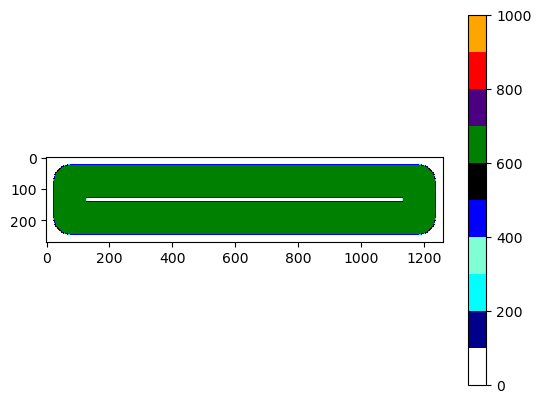

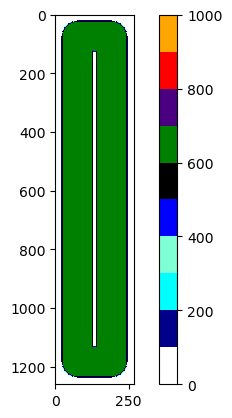

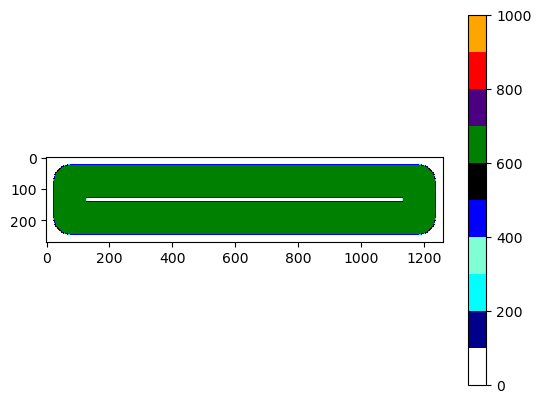

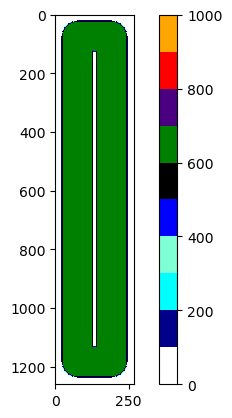

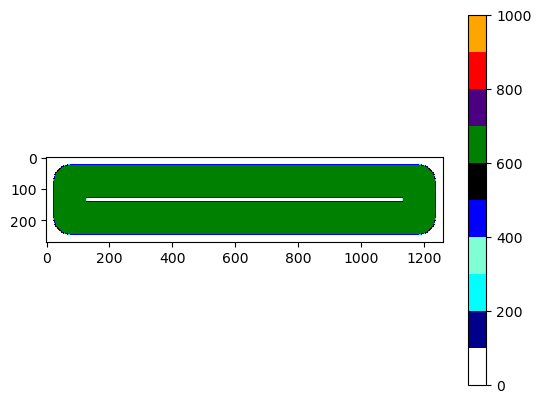

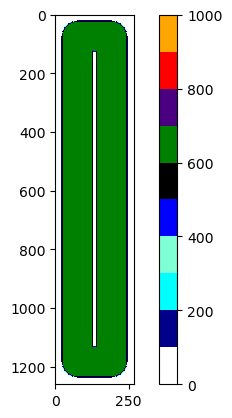

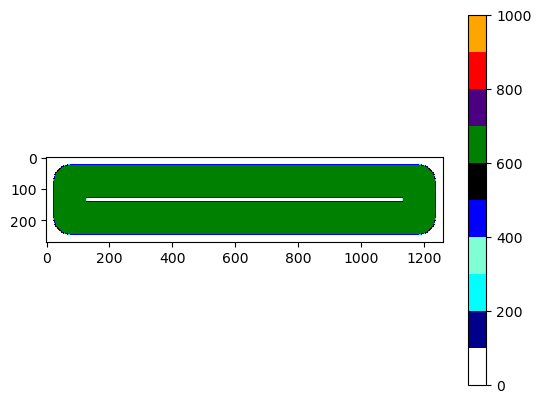

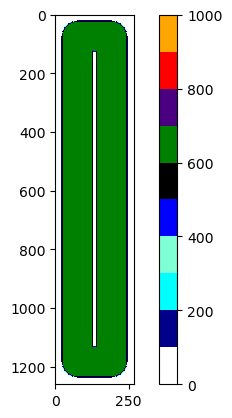

In [39]:
import gui
import files
from timer import Timer
from components import images_tools as it
from os import getcwd
import matplotlib.pyplot as plt
import matplotlib.colors
import os

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for c in camadas:
    folders.load_islands_hdf5(c)
tangran_cmap = matplotlib.colors.ListedColormap(["white","darkblue","aqua","aquamarine","blue","black","green","indigo","red","orange"])
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        plt.figure()
        img_mapping = it.final_mapping(c, folders)
        plt.imshow(img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.imsave("aaa.png",img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.colorbar()
        print('\n')

ROTAS

Rotas de Offset

In [40]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

amendment_size = 0.7 #porcentagem do tamanho da poca de deposicao de material
for c in camadas:
    with Timer("Making offset routes"):
        c.make_offset_routes(amendment_size, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.00528407096862793
Total de [Making offset routes] : 0.19980716705322266
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.005377054214477539
Total de [Making offset routes] : 0.2274627685546875
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.004716157913208008
Total de [Making offset routes] : 0.17038798332214355
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0058095455169677734
Total de [Making offset routes] : 0.20991015434265137
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.004362344741821289
Total de [Making offset routes] : 0.17266559600830078
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.00561833381652832
Total de [Making offset routes] : 0.2931203842163086
Making offset routes
salv

Rotas de pontes

In [41]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
[sob_int_ext_per] = gui.ask_parameters_internal_routes()

with Timer(f"Making bridges routes"):
    for c in camadas:
        with Timer(f"Camada: {c.name}"):
            c.make_bridges_routes(folders, sob_int_ext_per)
            %reset_selective -f "c"
%reset_selective -f "camadas"

Making bridges routes
Camada: L_000
Making Offset bridges routes
Total de [Making Offset bridges routes] : 9.512901306152344e-05
Making Zigzag bridges routes
Total de [Making Zigzag bridges routes] : 3.933906555175781e-05
Making Crossover bridges routes
Total de [Making Crossover bridges routes] : 2.6226043701171875e-05
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.003401041030883789
Total de [Camada: L_000] : 0.02480602264404297
Camada: L_001
Making Offset bridges routes
Total de [Making Offset bridges routes] : 8.511543273925781e-05
Making Zigzag bridges routes
Total de [Making Zigzag bridges routes] : 2.1696090698242188e-05
Making Crossover bridges routes
Total de [Making Crossover bridges routes] : 1.7404556274414062e-05
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0033550262451171875
Total de [Camada: L_001] : 0.020279645919799805
Camada: L_002
Making Offset bridges routes
Total de [Making Offset bridges routes] : 0.000115394592285156

Rotas de Ziguezague

In [42]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making zigzag routes"):
        c.make_zigzag_routes(folders)
        c.connect_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"



Making zigzag routes
criando as rotas de zigzag, camada:L_000
Total de [criando as rotas de zigzag, camada:L_000] : 0.0003230571746826172
salvando imagens das rotas
deletado: /L_000/I_000/zigzags
Total de [salvando imagens das rotas] : 0.001875162124633789
Criando os grafos de regiões
Total de [Criando os grafos de regiões] : 0.0006766319274902344
Conectando regiões de zigzag
Total de [Conectando regiões de zigzag] : 0.00044846534729003906
salvando grafos
Total de [salvando grafos] : 0.01592564582824707
Total de [Making zigzag routes] : 0.027939796447753906
Making zigzag routes
criando as rotas de zigzag, camada:L_001
Total de [criando as rotas de zigzag, camada:L_001] : 0.00027370452880859375
salvando imagens das rotas
deletado: /L_001/I_000/zigzags
Total de [salvando imagens das rotas] : 0.002386808395385742
Criando os grafos de regiões
Total de [Criando os grafos de regiões] : 0.0006570816040039062
Conectando regiões de zigzag
Total de [Conectando regiões de zigzag] : 0.000447034835

WEAVING

In [43]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
[iwflag] = gui.ask_parameters_weaving()
for c in camadas:
    with Timer("Fase 5 b"):
        c.internal_weaving(iwflag, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 0.15088367462158203
salvando rotas
deletado: /L_000/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.016561269760131836
Total de [Fase 5 b] : 0.16767501831054688
Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 0.15662932395935059
salvando rotas
deletado: /L_001/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.01922750473022461
Total de [Fase 5 b] : 0.17607712745666504
Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 0.14500999450683594
salvando rotas
deletado: /L_002/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.01687145233154297
Total de [Fase 5 b] : 0.16205334663391113
Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 0.1553037166595459
salvando rotas
deletado: /L_003/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.016572475433

Rotas de Thin Walls

In [44]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Fase 5"):
        with Timer("Making thin walls routes"):
            c.make_thin_wall_routes(folders)
            %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.00898885726928711
salvando imagens das rotas
Total de [salvando imagens das rotas] : 3.337860107421875e-06
Total de [Making thin walls routes] : 0.009137392044067383
Total de [Fase 5] : 0.009211540222167969
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.005308389663696289
salvando imagens das rotas
Total de [salvando imagens das rotas] : 3.0994415283203125e-06
Total de [Making thin walls routes] : 0.005440711975097656
Total de [Fase 5] : 0.0054492950439453125
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.0067102909088134766
salvando imagens das rotas
Total de [salvando imagens das rotas] : 4.0531158447265625e-06
Total de [Making thin walls routes] : 0.006859779357910156
Total de [Fase 5] : 0.006866455078125
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.0055158138275146484
salvando imagens das rotas
Total

Encontrando o lugar onde será o começo da trilha de cada ilha

In [45]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    c.islands_path_starts(folders)

%reset_selective -f "camadas"                        

Encontrando ponto de união ext-int
Total de [Encontrando ponto de união ext-int] : 0.00029540061950683594


IndexError: list index out of range

Unificando rotas EXTERNAS nas camadas

In [ ]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer(f"Fase 6: layer_{c.name}"):
        c.close_routes_external(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"
    

Fase 6: layer_L_000
Conectando rotas externas
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 0.00899362564086914
Conectando pontes de Crossover
Total de [Conectando pontes de Crossover] : 0.010881185531616211
Total de [Conectando rotas externas] : 0.05690407752990723
salvando imagens das rotas
deletado: /L_000/I_000/external_tree_route
Total de [salvando imagens das rotas] : 0.025685787200927734
Total de [Fase 6: layer_L_000] : 0.08285784721374512
Fase 6: layer_L_001
Conectando rotas externas
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 0.009219169616699219
Conectando pontes de Crossover
Total de [Conectando pontes de Crossover] : 0.010924577713012695
Total de [Conectando rotas externas] : 0.054931640625
salvando imagens das rotas
deletado: /L_001/I_000/external_tree_route
Total de [salvando imagens das rotas] : 0.027545928955078125
Total de [Fase 6: layer_L_001] : 0.0827336311340332
Fase 6: layer_L_002
Conectando rotas externas
Conectando 

Unificando rotas INTERNAS nas camadas

In [ ]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer(f"Fase 7: Layer_{c.name}"):
        c.close_routes_internal(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 7: Layer_L_000
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 0.00423121452331543
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.00036835670471191406
salvando imagens das rotas
deletado: /L_000/I_000/internal_tree_route
Total de [salvando imagens das rotas] : 0.021242856979370117
Total de [Fase 7: Layer_L_000] : 0.06461834907531738
Fase 7: Layer_L_001
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 0.003103494644165039
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.0003628730773925781
salvando imagens das rotas
deletado: /L_001/I_000/internal_tree_route
Total de [salvando imagens das rotas] : 0.022687673568725586
Total de [Fase 7: Layer_L_001] : 0.059848785400390625
Fase 7: Layer_L_002
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 0.004007577896118164
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.0003497600555419922
salvando imagens das rotas
deletad

Unindo rotas de thin walls

In [ ]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer(f"Fase 8: Layer_{c.name}"):
        c.close_routes_thinwalls(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 8: Layer_L_000
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0002810955047607422
salvando imagens das rotas
deletado: /L_000/I_000/thinwalls_tree_route/sequence
deletado: /L_000/I_000/thinwalls_tree_route/saltos
Total de [salvando imagens das rotas] : 0.018724679946899414
Total de [Fase 8: Layer_L_000] : 0.02672123908996582
Fase 8: Layer_L_001
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0002887248992919922
salvando imagens das rotas
deletado: /L_001/I_000/thinwalls_tree_route/sequence
deletado: /L_001/I_000/thinwalls_tree_route/saltos
Total de [salvando imagens das rotas] : 0.02018904685974121
Total de [Fase 8: Layer_L_001] : 0.02900552749633789
Fase 8: Layer_L_002
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.00041294097900390625
salvando imagens das rotas
deletado: /L_002/I_000/thinwalls_tree_route/sequence
deletado: /L_002/I_000/thinwalls_tree_route/saltos
Total de [salvando imagens das rotas] : 0.0196528434753417

Unindo todas as rotas

In [26]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    c.close_final_path(folders)

%reset_selective -f "camadas"


Encontrando ponto de união ext-int
Total de [Encontrando ponto de união ext-int] : 0.005472421646118164
Conectando todas as partes
Total de [Conectando todas as partes] : 0.3398561477661133
salvando imagens das rotas
deletado: /L_000/I_000/island_route
[[93, 1005], [93, 1132], [94, 1133], [94, 1140], [95, 1141], [95, 1143], [96, 1144], [96, 1146], [97, 1147], [97, 1148], [98, 1149], [98, 1150], [100, 1152], [100, 1153], [107, 1160], [108, 1160], [110, 1162], [111, 1162], [112, 1163], [113, 1163], [114, 1164], [116, 1164], [117, 1165], [119, 1165], [120, 1166], [127, 1166], [128, 1167], [187, 1167], [188, 1166], [195, 1166], [196, 1165], [198, 1165], [199, 1164], [201, 1164], [202, 1163], [203, 1163], [204, 1162], [205, 1162], [207, 1160], [208, 1160], [215, 1153], [215, 1152], [217, 1150], [217, 1149], [218, 1148], [218, 1147], [219, 1146], [219, 1144], [220, 1143], [220, 1141], [221, 1140], [221, 1133], [222, 1132], [222, 655], [223, 654], [256, 654], [257, 655], [257, 1184], [256, 11

Gerando o Código G

In [ ]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[vel_vazio, p_entre_int_ext, p_entre_camadas, substratoy, substratox, cortey, cortex] = gui.ask_parameters_Gcode()
coords_substrato = [substratoy, substratox]
coords_corte = [cortey, cortex]
camadas = folders.load_layers_hdf5()
configuracoes = files.Config("solda_config.yaml")

#layer_heights = [10+2.9+3+(i*1.5) for i,x in enumerate(camadas)]
layer_heights = [40+8+2.5+(i*2) for i,x in enumerate(camadas)]
with Timer("Cuspindo o Gcode"):
    path_tools.layers_to_Gcode(camadas, 
                               folders, 
                               configuracoes,
                               vel_vazio,
                               p_entre_int_ext,
                               p_entre_camadas,
                               layer_heights,
                               coords_substrato,
                               coords_corte,
                               )
%reset_selective -f "camadas"

Cuspindo o Gcode
Deslocamento total da camada 0 = 642.1227984935065mm
Tempo estimado com Vel=360.0mm/min = 1.7836744402597402min

Deslocamento total da camada 1 = 640.7554549847789mm
Tempo estimado com Vel=360.0mm/min = 1.7798762638466081min

Deslocamento total da camada 2 = 642.1227984935065mm
Tempo estimado com Vel=360.0mm/min = 1.7836744402597402min

Deslocamento total da camada 3 = 640.7554549847785mm
Tempo estimado com Vel=360.0mm/min = 1.7798762638466068min

Deslocamento total da camada 4 = 641.9740087383491mm
Tempo estimado com Vel=360.0mm/min = 1.783261135384303min

Deslocamento total da camada 5 = 640.7554549847785mm
Tempo estimado com Vel=360.0mm/min = 1.7798762638466068min

Deslocamento total da camada 6 = 583.5807041039883mm
Tempo estimado com Vel=360.0mm/min = 1.6210575113999675min

Deslocamento total da camada 7 = 640.6066652296214mm
Tempo estimado com Vel=360.0mm/min = 1.7794629589711706min

Total de [Cuspindo o Gcode] : 0.4638826847076416


Comprimento da trajetória

In [28]:
import os
import numpy as np
import math

with open("traj interna.txt") as f:
    lido = f.readlines()
    f.close()
lido = [x.strip("\n") for x in lido] 
lido = [x.split(", ") for x in lido] 
lido = lido[:-1]
lido = [[float(x[0]), float(x[1])] for x in lido]
modulos = [math.sqrt((x[0]**2)+(x[1]**2)) for x in lido]
comprimento = np.sum(modulos)
print(f'comprimento da trajetoria={comprimento}')

area_preench = 11 #mm² do imageJ
raio_toroide = 37.5 # mm medido
comp_traj = comprimento #mm do codigo G calculado acima
diam_fio = 1.2 #mm medido
area_fio = math.pi*((diam_fio/2)**2) #mm²
vol_preench = (2*math.pi*raio_toroide*area_preench)
Ws_Vd = vol_preench/(area_fio*comp_traj)
print(f'Relação de velocidades:{Ws_Vd}')

comprimento da trajetoria=405.95021132343504
Relação de velocidades:5.645191461277042


In [29]:
# import numpy as np
# camadas = folders.load_layers_hdf5()
# for c in camadas:
#     folders.load_islands_hdf5(c)
#     for isl in c.islands:
#         folders.load_island_paths_hdf5(c.name, isl)
#         internal_trees = [list(x) for x in isl.internal_tree_route.sequence]
#         print(internal_trees)
# print([235,807] in internal_trees)

In [30]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Lista de imagens binárias (exemplo com arrays numpy)
# imagens = [
#     img_mapping,
#     img_mapping,
#     img_mapping
# ]

# # Lista de alturas no eixo z
# alturas = [0, 10, 20]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for img, z in zip(imagens, alturas):
#     x = np.linspace(0, img.shape[1], img.shape[1])
#     y = np.linspace(0, img.shape[0], img.shape[0])
#     x, y = np.meshgrid(x, y)
#     z = np.full_like(x, z)
#     ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(img), shade=False)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()


In [31]:
# import gui
# import files
# from timer import Timer
# from components import layer, path_tools
# from os import getcwd

# if not('folders' in globals()):
#     home = getcwd()
#     folders = files.System_Paths(home)
#     gui.find_saved_file(folders)
# camadas = folders.load_layers_hdf5()

# file_name = gui.find_saved_file(folders)
# path_tools.layers_to_Gcode_FFF(camadas, folders, file_name)

In [32]:
# class TrafficLightState:
#     """Base class for traffic light states."""
#     def change(self, traffic_light):
#         raise NotImplementedError("This method should be overridden by subclasses")


# class RedState(TrafficLightState):
#     """State representing the red light."""
#     def change(self, traffic_light):
#         print("Changing from Red to Green")
#         traffic_light.state = GreenState()


# class YellowState(TrafficLightState):
#     """State representing the yellow light."""
#     def change(self, traffic_light):
#         print("Changing from Yellow to Red")
#         traffic_light.state = RedState()


# class GreenState(TrafficLightState):
#     """State representing the green light."""
#     def change(self, traffic_light):
#         print("Changing from Green to Yellow")
#         traffic_light.state = YellowState()


# class TrafficLight:
#     """Traffic light class that uses a state machine."""
#     def __init__(self):
#         self.state = RedState()  # Initial state

#     def change(self):
#         """Change the state of the traffic light."""
#         self.state.change(self)

#     def __str__(self):
#         return f"Current state: {self.state.__class__.__name__}"


# # Example usage
# if __name__ == "__main__":
#     traffic_light = TrafficLight()
    
#     # Simulate the traffic light changing states
#     for _ in range(6):  # Change state 6 times
#         print(traffic_light)
#         traffic_light.change()

In [33]:
# import numpy as np
# import cv2  # Assuming you are using OpenCV for image processing

# def bobobo(image1, image2):
#     """A placeholder function that performs some operation on two images."""
#     # For demonstration, let's just return the absolute difference between the two images
#     return cv2.absdiff(image1, image2)

# def process_images(image_list):
#     """Process a list of images, comparing the last two with the current image."""
#     for i in range(len(image_list)):
#         current_image = image_list[i]
        
#         # Check if there are at least two previous images to compare
#         if i >= 2:
#             last_image = image_list[i - 1]
#             second_last_image = image_list[i - 2]
            
#             # Apply the bobobo function to the current image and the last two images
#             result_last = bobobo(current_image, last_image)
#             result_second_last = bobobo(current_image, second_last_image)
            
#             # Here you can do something with the results, like saving or displaying them
#             # For demonstration, we'll just print the shapes of the results
#             print(f"Comparing image {i} with last image {i-1}: result shape = {result_last.shape}")
#             print(f"Comparing image {i} with second last image {i-2}: result shape = {result_second_last.shape}")

# # Example usage
# if __name__ == "__main__":
#     # Create a list of dummy images (for demonstration purposes)
#     # In practice, you would load your images using cv2.imread or similar
#     image_list = [np.random.randint(0, 256, (100, 100, 3), dtype=np.uint8) for _ in range(5)]
    
#     process_images(image_list)